# Introduction to explainable AI (XAI)

MolPipeline supports explainability methods for machine learning models, also called explainable AI (XAI). Explainability methods provide explanations for predictions, which can help to interprete why a model made a prediction. This can be helpful to user for decision making and for developers to improve machine learning models.   

MolPipeline provides easy and fast generation of XAI explanations with standard approaches like Random Forest with Morgan fingerprints. In this notebook, we borrow a real-world drug design data set from [Harren et al. 2022](https://pubs.acs.org/doi/10.1021/acs.jcim.1c01263) and illustrate how explanations generated with MolPipeline can be used in real-world scenarios. The study by Harren et al. is a comprehensive analysis of methods for interpreting structure–activity relationships (SARs) in lead optimization with XAI from Sanofi and the University Hamburg and worth checking out.

The XAI method implemented in MolPipeline and presented here was introduced by [Feldmann et al. 2022](https://doi.org/10.3390/biom12040557) and uses Shapley Values from [SHAP](https://github.com/shap/shap) to explain important atoms and substructures with a heatmap on the 2D depcition of the molecular structure. For the implementation see MolPipelines `explainability` module.

In [1]:
from pathlib import Path

from rdkit import Chem
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pandas as pd

from molpipeline import Pipeline
from molpipeline.any2mol import AutoToMol
from molpipeline.mol2any import MolToMorganFP
from molpipeline.explainability import (
    SHAPTreeExplainer,
    structure_heatmap_shap,
    structure_heatmap,
)

In [2]:
RANDOM_STATE = 123456

## Reading the protein-ligand binding data set

The data set contains bioactivity measurements describing the binding of small molecules (the ligands) and the protein target.

The bioactivity is provided as pIC50 values against the aspartic protease renin for molecular series of indole-3-carboxamides and azaindoles. The structure−activity relationship (SAR) is relatively well understood for these molecules. For example, for the indole-3-carboxamides, a PDB structure of the protein-ligand complex is available [3oot](https://www.rcsb.org/structure/3OOT), illustrating the interactions of the potent ligand "5k" (IC50=2 nM), that can be used to evaluate XAI explanations. See the paper of [Harren et al.](https://pubs.acs.org/doi/10.1021/acs.jcim.1c01263) for useful details and references.

Let's read in the molecular data.

In [3]:
data_path = "/home/siegjo/projects/sideprojects/harren_2022_data_chembl_pubchem_api_extract/renin_harren.csv"
df = pd.read_csv(data_path)
df

,pubchem_cid,pubchem_inchi,pubchem_smiles,name,origin,pIC50
0,54753101.0,InChI=1S/C26H25FN4O2/c1-17-10-11-20(27)18(2)24...,CC1=C(C(=C(C=C1)F)C)OC2=C(C3=C(N2C4=CC=CC=C4)C...,b2a3m,BMCL2011A,8.8861
1,52949598.0,InChI=1S/C26H24FN3O3/c1-17-7-8-18(27)15-23(17)...,CC1=C(C=C(C=C1)F)OC2=C(C3=C(N2C4=CC=CC=C4)C=CC...,b1i5c,BMCL2010,8.6990
2,44195154.0,InChI=1S/C28H28FN3O2/c1-18-20(7-6-10-22(18)29)...,CC1=C(C=CC=C1F)CC2=C(C3=C(N2C4=CC=CC=C4)C=CC(=...,b1i5k,BMCL2010,8.6990
3,44194118.0,InChI=1S/C26H25FN4O2/c1-17-8-9-21(27)18(2)24(1...,CC1=C(C(=C(C=C1)F)C)OC2=C(C3=C(N2C4=CC=CC=C4)C...,b2a6d,BMCL2011A,8.6990
4,53346499.0,InChI=1S/C32H29FN4O2/c1-22-12-13-24(33)21-28(2...,CC1=C(C=C(C=C1)F)OC2=C(C3=C(N2C4=CC=CC=C4)C(=N...,b2a7d,BMCL2011A,8.5229
...,...,...,...,...,...,...
133,52947015.0,InChI=1S/C26H25N3O2/c1-19-18-28(17-16-27-19)25...,CC1CN(CCN1)C(=O)C2=C(N(C3=CC=CC=C32)C4=CC=CC=C...,b1i3a,BMCL2010,5.1898
134,56675445.0,InChI=1S/C26H25FN4O3/c1-17-8-9-18(27)16-21(17)...,CC1=C(C=C(C=C1)F)OC2=C(C3=C(N2C4=CC=CC=C4)C=CC...,b2a5a,BMCL2011A,5.1785
135,52944458.0,InChI=1S/C27H27N3O2/c1-27(2)19-29(18-17-28-27)...,CC1(CN(CCN1)C(=O)C2=C(N(C3=CC=CC=C32)C4=CC=CC=...,b1i3b,BMCL2010,5.1367
136,52948980.0,"InChI=1S/C26H22F3N3O2/c27-26(28,29)18-7-6-10-2...",C1CN(CCN1)C(=O)C2=C(N(C3=CC=CC=C32)C4=CC=CC=C4...,b1i2c,BMCL2010,5.0458


A small note on the data sets:  
We use a version of the Renin data set from PubChem because of licensing and automatic downloading from the journal website is prevented. This version contains only 138 instead of the original 142 compounds, since the missing molecules were not available in PubChem. This difference should be negligible for the purpose of this notebook. 

We construct RDKit molecule data structures from the SMILES and add relevant infos as properties to the molecules for convenience.


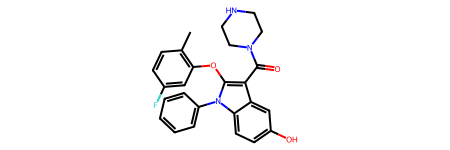

In [4]:
mols = [Chem.MolFromSmiles(smiles) for smiles in df["pubchem_smiles"]]
for prop_name in ["name", "origin", "pIC50"]:
    for mol, prop in zip(mols, df[prop_name]):
        mol.SetProp(prop_name, str(prop))
mols[1]

The target values are extraxted in a separate list `y`

In [5]:
y = [float(mol.GetProp("pIC50")) for mol in mols]
y[:3]

[8.8861, 8.699, 8.699]

## Explaining predictions with MolPipeline

We start by setting up and fitting a standard Random Forest model with Morgan fingerprints on the data set with a pipeline.

In [6]:
pipeline = Pipeline(
    [
        ("auto2mol", AutoToMol()),
        ("morgan", MolToMorganFP(n_bits=2048, radius=3)),
        ("rf", RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE)),
    ],
    n_jobs=-1,
)

pipeline.fit(mols, y)

Pipeline(n_jobs=-1,
         steps=[('auto2mol', AutoToMol()), ('morgan', MolToMorganFP(radius=3)),
                ('rf',
                 RandomForestRegressor(n_estimators=500, random_state=123456))])

After the model is trained, we can simply pass the `pipeline` into a MolPipeline explainer object and call the `explain` function to generate explanations for a list of molecules. Here we use the `SHAPTreeExplainer` which is a wrapper around [SHAP's TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) that handles all necessary steps to generate explanations for molecules automatically. In addition, all molecules given to `explain` will be processed by the `pipeline` meaning all transformation, standardization and error handling steps will also be applied to explaining molecules.

In [7]:
explainer = SHAPTreeExplainer(pipeline)
explanations = explainer.explain(mols)

We can check if an explanation could be computed successfully by calling the `is_valid()` function, e.g. sometimes errors can occur for unprocessable molecules. 

In [8]:
assert all(exp for exp in explanations if not exp.is_valid())

The algorithm behind MolPipeline's `SHAPTreeExplainer` uses [SHAP's TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) to estimate Shapley Values. With the Shapley Values each feature is attributed an importance value for the prediction, which we term `feature_weights`. When computed on the Morgan fingerprint, these `feature_weigths` can be mapped to `atom_weights`. The weight of an atom is the sum of all feature weights of substructures intersecting the atom, normalized by the substructure size and occurrence in the molecule. See [Feldmann et al.](https://doi.org/10.3390/biom12040557) for more details and [Harren et al.](https://pubs.acs.org/doi/10.1021/acs.jcim.1c01263) for some alternative approaches for calculating atom weights.

In [9]:
# feature weights for the first molecule
explanations[0].feature_weights

array([0.        , 0.00033001, 0.00010306, ..., 0.        , 0.00025244,
       0.        ])

In [10]:
# atom weights for the first molecule
explanations[0].atom_weights

array([ 0.12741071,  0.13919019,  0.07593206,  0.13930674,  0.08594195,
        0.01826992,  0.07099029,  0.03481592,  0.13192108,  0.0763856 ,
        0.06904259,  0.06558726,  0.06548176,  0.0672983 ,  0.0670064 ,
        0.05595265,  0.00196574,  0.00114999,  0.00072739,  0.00114999,
        0.00196574,  0.00710791, -0.00021892,  0.00095641, -0.00198274,
        0.06092596,  0.00555693,  0.00703136,  0.00723796,  0.00834429,
        0.00433498,  0.00834429,  0.00723796])

## Visualizing explanations with MolPipeline

Now that we generated explanations, let's depict one to understand how they can be used for interpreting predictions. 

We select some molecule from the data set:

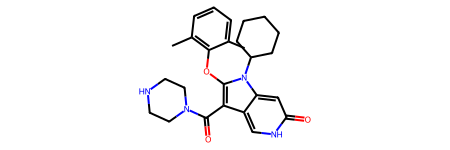

In [11]:
explanation = explanations[50]
explanation.molecule

We can illustrate MolPipeline's explanations with the `structure_heatmap_shap` as can be seen in the next cell. 

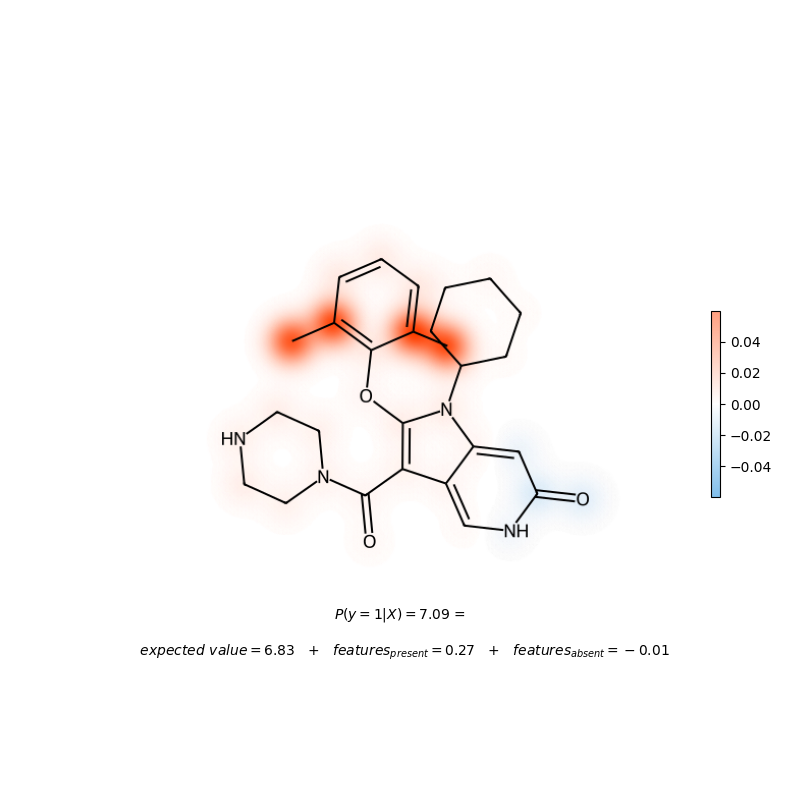

In [12]:
structure_heatmap_shap(
    explanation
)

The image shows a depiction of the 2D molecular structure. In addition, the explanation results are illustrated as a heatmap and the contribution of substructure features present or absent in the molecule.

**Heatmap of the molecular structure**  
Substructures associated with positive contributions by the model are highlighted in red, while substructures with negative contributions would be illustrated in blue. No color indicates no contribution. Therefore, we can interprete that substructures highlighted in red are important for high activity while blue substructures are unfavorable for activity. 

**Contribution of present/absent substructure features**  
In addition to the heatmap of the structure, MolPipelines also provides a breakdown of the predicted value on the bottom of the explanation image. The model predicts a pIC50 value of TODO=6.72 for the compound. This value can be decomposed in contributions from the expected value of the model output (see [Lundberg et al.](https://doi.org/10.48550/arXiv.1705.07874) for details), the features present and features absent using the Shapley Value-based feature weights. Since we are using Morgan fingerprints, present features correspond to the substructures present in the molecule, that can be seen in the image. In contrast, absent features are features that are important for the prediction but are not in the depicted molecule. For example, some features/substructures in the training set can be important for the model and that they are missing in this particular molecule influences the prediction.  

Note that this decomposition is currently only provided for binary fingerprints.

## Comparison to explanations from Harren et al.

To demonstrate the usage of MolPipeline's XAI features we will reproduce some of the explanation results from [Harren et al.](https://pubs.acs.org/doi/10.1021/acs.jcim.1c01263) with our standard Random Forest model with Morgan fingeprints based on Shapley values. In contrast, Harren et al. used simple multilayer perceptrons with Morgan/ECFP fingerprints and graph convolutional neural networks. 

In the lead optimization step in drug discovery, it is important that a machine learning model reflects the affinity trends induced by smaller structural changes. Especially, small structural changes causing large affinity changes are of interest and the interpretations obtained from an XAI method should adequately capture and visualize these trends. The goal of applying XAI in such a project is usually to identify further small structural modification to improve affinity. Again, see [Harren et al.](https://pubs.acs.org/doi/10.1021/acs.jcim.1c01263) for details.  

For convenience we store all explanations in a dict to access them by the molecules IDs or names.

In [13]:
explanations_dict = {exp.molecule.GetProp("name"): exp for exp in explanations}
len(explanations_dict)

138

We will compare our explanation with the explanations in Figure 6 in Harren et al. Therefore, we extract the 3 compounds of different affinities:

- 5k (PDB 3oot), b1i5k, exp. IC50=0.002, exp. pIC50=8.70, predicted(ours)=TODO 
- 2n, b1i2n, 
- 5b, b1i5b

In [14]:
df["origin"].value_counts()

origin
BMCL2011A    54
BMCL2010     45
BMCL2011B    39
Name: count, dtype: int64

In [15]:
from molpipeline.estimators import MurckoScaffoldClustering
scaffold_clustering = MurckoScaffoldClustering(
    make_generic=True, linear_molecules_strategy="own_cluster", n_jobs=16
)
cluster_ids = scaffold_clustering.fit_predict(df["pubchem_smiles"])
cluster_ids

array([4., 4., 4., 4., 1., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 2., 4., 4., 4., 9., 0., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 9.,
       4., 4., 4., 9., 4., 4., 4., 9., 4., 4., 4., 4., 4., 9., 4., 4., 4.,
       4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 8., 4.,
       4., 4., 4., 4., 4., 6., 3., 4., 5., 4., 4., 8., 4., 4., 4., 4., 4.,
       4., 7.])

In [16]:
seen_cids = {}
for i, cid in enumerate(cluster_ids):
    if cid not in seen_cids:
        seen_cids[cid] = i
seen_cids

{4.0: 0,
 1.0: 4,
 2.0: 27,
 9.0: 31,
 0.0: 32,
 5.0: 71,
 8.0: 117,
 6.0: 124,
 3.0: 125,
 7.0: 137}

In [17]:
from molpipeline.mol2mol import MakeScaffoldGeneric

repr_mols = [mols[i] for i in seen_cids.values()]
scaffold_mols = MakeScaffoldGeneric().transform(repr_mols)

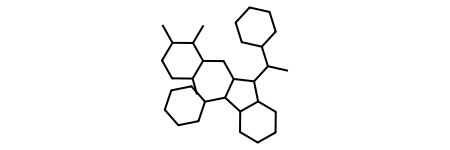

In [18]:
scaffold_mols[0]

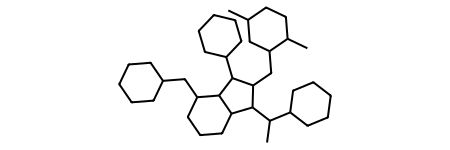

In [19]:
scaffold_mols[1]

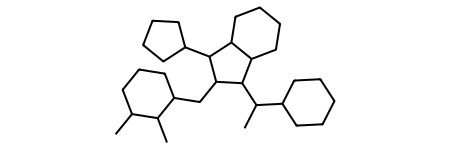

In [20]:
scaffold_mols[2]

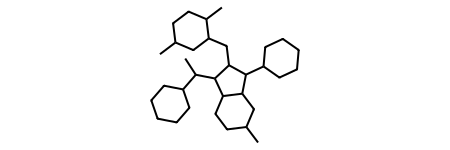

In [21]:
scaffold_mols[3]

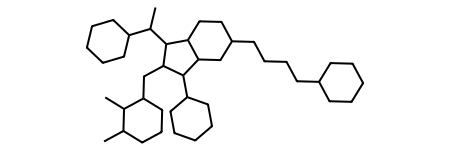

In [22]:
scaffold_mols[4]

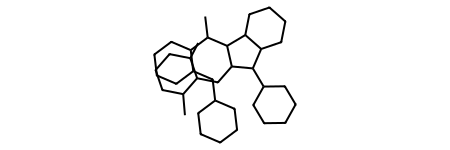

In [23]:
scaffold_mols[5]

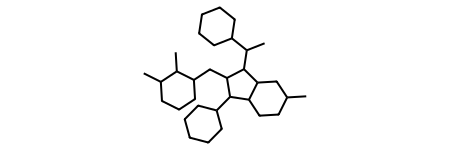

In [24]:
scaffold_mols[6]

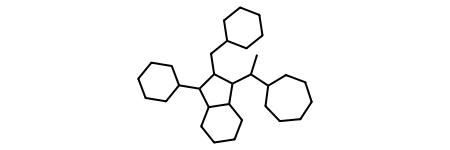

In [25]:
scaffold_mols[7]

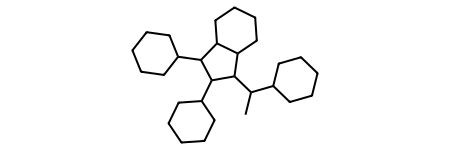

In [26]:
scaffold_mols[8]

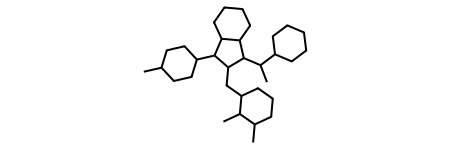

In [27]:
scaffold_mols[9]

In [28]:
# series_names = ["b1i5k", "b1i2n", "b1i5b"]
# series_dict = {k:explanations_dict[k] for k in series_names}
series_dict = explanations_dict

Extract the min and max atom weight values for normalizing the coloring of the series

In [48]:
weight_min = min([exp.atom_weights.min() for exp in series_dict.values()])
weight_max = max([exp.atom_weights.max() for exp in series_dict.values()])
weight_abs_max = max(abs(weight_min), abs(weight_max))
# following Harren et al., we set the maximum color intensity to 70% of the maximal numerical value
# for better visual differentiations in low value regions.
weight_abs_max = weight_abs_max * 0.70

In [46]:
weight_abs_max

0.5794024369353806

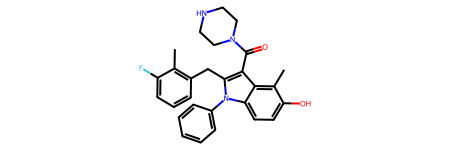

In [30]:
# most potent compound from series (Scheiper 2010)
explanations_dict["b1i5k"].molecule

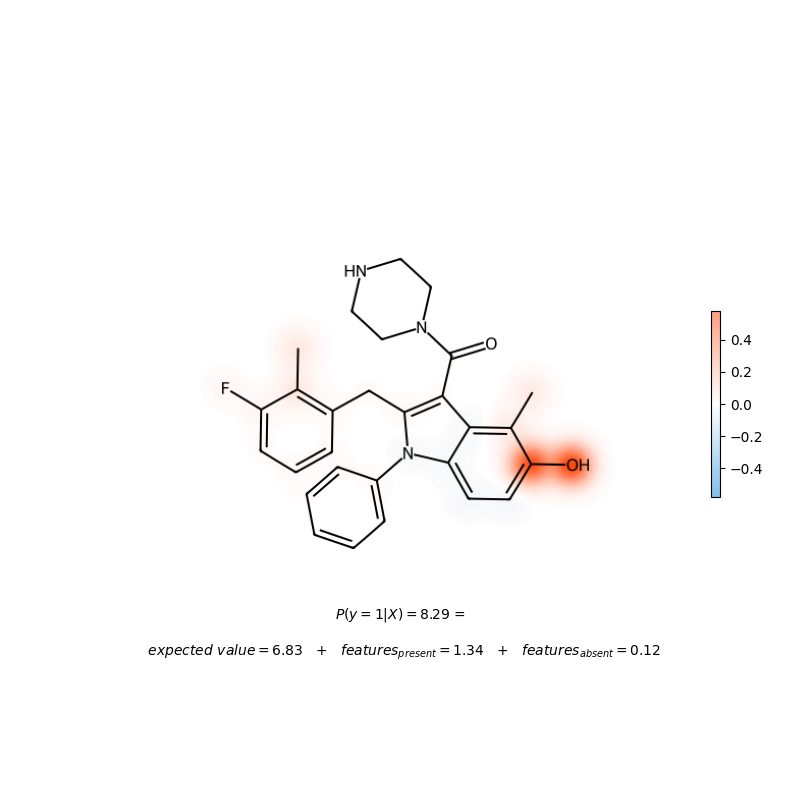

In [47]:
structure_heatmap_shap(explanations_dict["b1i5k"], color_limits=(-weight_abs_max, weight_abs_max))

The heatmap explanation strongly highlights the indoles hydroxyl group decoration.  

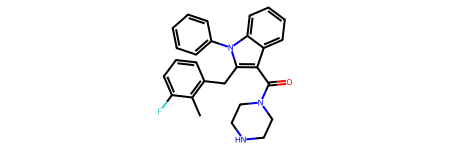

In [32]:
# molecule depicted in Figure 5 of Harren et al. (mislabeled as "5k" in Figure caption)
explanations_dict["b1i2n"].molecule

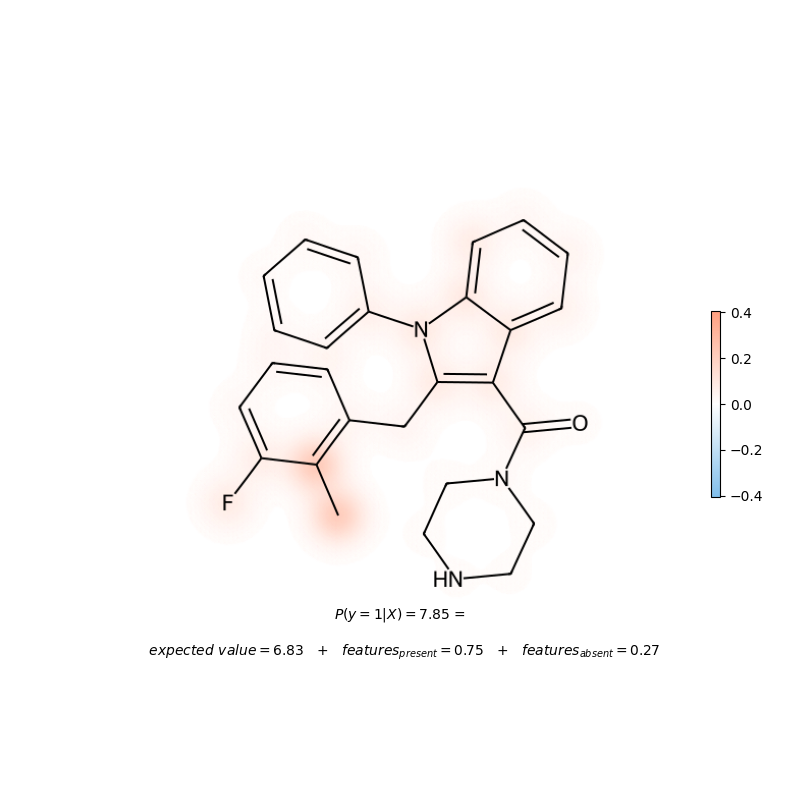

In [50]:
structure_heatmap_shap(explanations_dict["b1i2n"], color_limits=(-weight_abs_max, weight_abs_max))

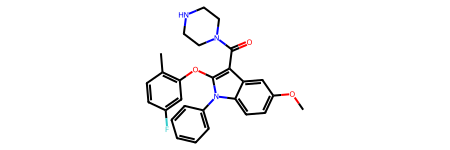

In [34]:
# compound "5b" in Figure 6 from Harren et al.
explanations_dict["b1i5b"].molecule

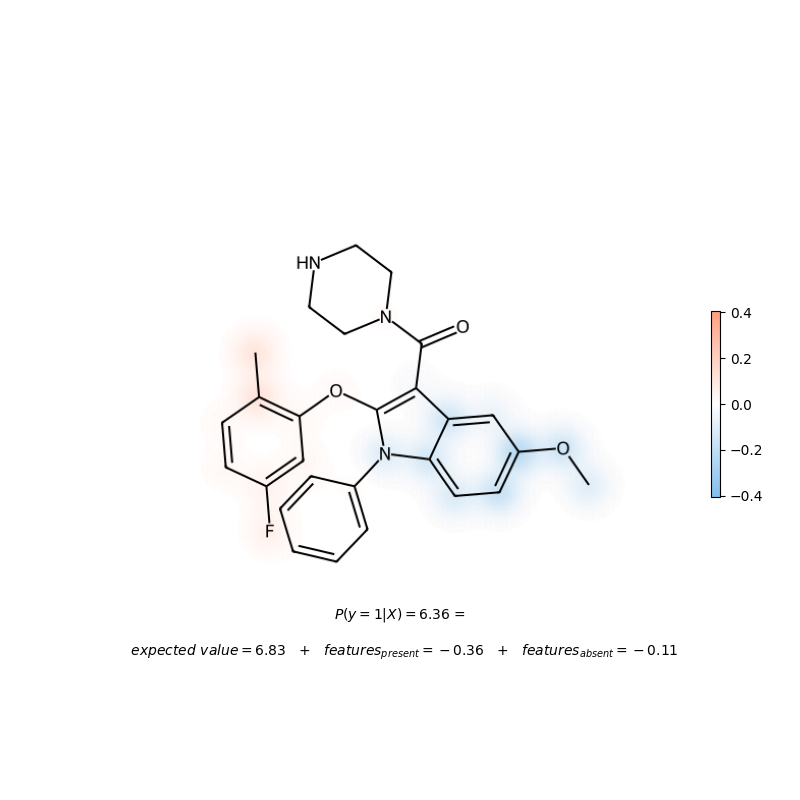

In [51]:
structure_heatmap_shap(explanations_dict["b1i5b"], color_limits=(-weight_abs_max, weight_abs_max))

**An important note:**
It is essential to inteprete all explanations in the context of the data set and models used. This is also a point nicely highlighted by Harren et al. in their paper. For example, for interpreting SAR results it is important to know which part of the molecules were exchanged and which were kept static during the exploration and therefore in the data set. Substituents that are the same in all molecules of the series will likely have neutral influence on the model predictions. However, exchanging them might have a large negative or positive effect on affinity, which is likely not captured by the data, the model and the explanations.   